In [1]:
import numpy as np
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import log_loss

from preprocess import preprocess
from model_utils import split
from make_plots import get_data

Using TensorFlow backend.


In [2]:
pred_dict = {
    "ensemble": "models/pred_only_disc.npy",
    "baseline": "models/pred_whole_data.npy",
#     "baseline bez_disc": "models/pred_without_disc.npy",
    "XGBoost": "models/pred_xgb_whole_data.npy",
#     "XGBoost bez_disc": "models/pred_xgb_without_disc.npy",
    "best-nn": "models/pred_new_whole_data.npy",
#     "best-nn bez klasyfikatorów": "models/pred_new_without_disc.npy",
#     "best-nn bez_disc": "models/pred_new_without_disc.npy",
#     "best-nn bez głównej zmiennej": "models/pred_new_without_BCI.npy",
}

In [3]:
y_true, y_preds = get_data("htt_features_test.pkl", pred_dict)

deepTau


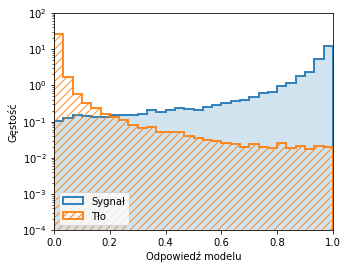

ensemble


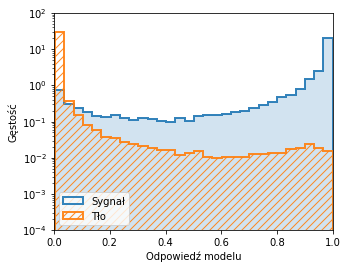

baseline


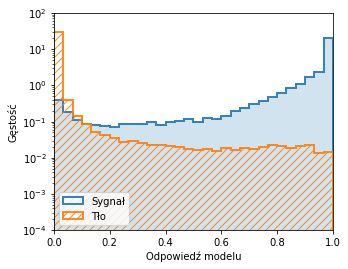

XGBoost


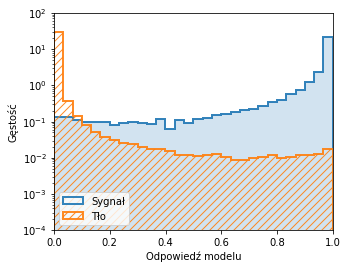

best-nn


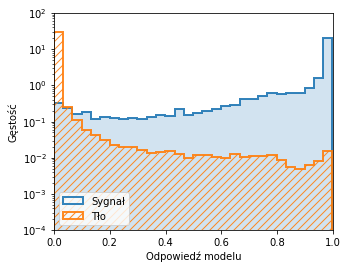

In [5]:
for k, v in y_preds.items():
    print(k)
    v = np.squeeze(np.array(v))
    plt.figure(figsize=(5, 4))
    ax = plt.subplot()
    ax.set_yscale("log")
    bins = np.histogram(v, bins=30)[1]
    plt.hist(v[np.squeeze(y_true) == 1], density=True, bins=bins, alpha=0.2, color="C0")
    plt.hist(v[np.squeeze(y_true) == 1], density=True, bins=bins, alpha=0.9, histtype="step", 
             linewidth=2, color="C0", label="Sygnał")
#     plt.hist(X[y == 0, i], density=True, bins=bins, alpha=0.4, color="", hatch="//", edgecolor="C1",
#              label="Tło",)
    plt.hist(v[np.squeeze(y_true) == 0], density=True, bins=bins, alpha=0.9, histtype="step", hatch="///", edgecolor="C1",
             linewidth=2, color="C1", label="Tło")
#     sns.kdeplot(v[np.squeeze(y_true) == 1], label="Sygnał", shade=True, gridsize=100)
#     sns.kdeplot(v[np.squeeze(y_true) == 0], linestyle="dashed", label="Tło", shade=True, gridsize=100)
    plt.xlabel("Odpowiedź modelu")
    plt.ylabel("Gęstość")
    plt.xlim((0, 1))
    plt.ylim((1e-4, 1e2))
    plt.legend(loc=3)
    plt.savefig("praca/density_" + k + ".png", dpi=500)
    plt.show()

In [7]:
loss_dict = {
    "ensemble": "only_disc.npy",
    "baseline": "whole_data.npy",
    "best-nn": "new_whole_data.npy",
}

batch_dict = {
    "ensemble": 128,
    "baseline": 128,
    "best-nn": 256,
}

ensemble


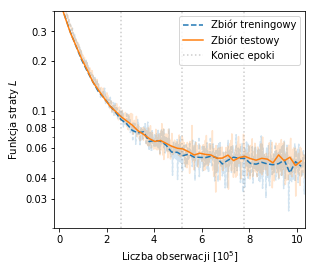

baseline


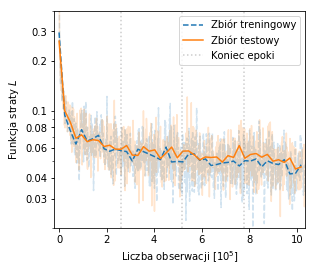

best-nn


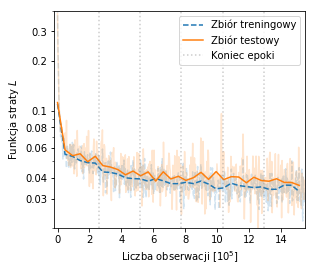

In [13]:
for k, v in loss_dict.items():
    mean_n = 11
    mean_n2 = 184
    mult = 1e5
    train_loss = np.squeeze(np.load("models/train_losses_" + v))
    length = len(train_loss)*batch_dict[k]
    train_loss2 = np.mean(train_loss.reshape(-1, mean_n2), axis=1)
    train_loss = np.mean(train_loss.reshape(-1, mean_n), axis=1)
    
    val_loss = np.squeeze(np.load("models/val_losses_" + v))
    val_loss2 = np.mean(val_loss.reshape(-1, mean_n2), axis=1)
    val_loss = np.mean(val_loss.reshape(-1, mean_n), axis=1)
    print(k)
    plt.figure(figsize=(4.5, 4))
    plt.semilogy(np.arange(len(train_loss))*mean_n*batch_dict[k]/mult, train_loss, 
                 alpha=0.2, linestyle="--")
    plt.semilogy(np.arange(len(val_loss))*mean_n*batch_dict[k]/mult, val_loss, alpha=0.2)
    
    plt.semilogy(np.arange(len(train_loss2))*(mean_n2+1)*batch_dict[k]/mult, train_loss2, 
                 color="C0",linestyle="--", label="Zbiór treningowy")
    plt.semilogy(np.arange(len(val_loss2))*(mean_n2+1)*batch_dict[k]/mult, val_loss2, 
                 color="C1", label="Zbiór testowy")
    
    for i in range(1, int(length/259042)):
        label = ""
        if i == 1:
            label = "Koniec epoki"
        plt.axvline((i*259042/mult), alpha=0.4, color="grey", label=label, linestyle=":")
        
    plt.ylim((2e-2, 4e-1))
    plt.xlim((-0.2, len(train_loss2)*mean_n2*batch_dict[k]/mult))
    plt.xlabel("Liczba obserwacji " + r"$[10^5]$")
    plt.ylabel("Funkcja straty " + r"$L$")
    plt.yticks([3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1], 
               [3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1])
    plt.legend(loc=1)
    plt.savefig("praca/loss_" + k + ".png", dpi=500)
    plt.show()

ensemble
baseline
best-nn


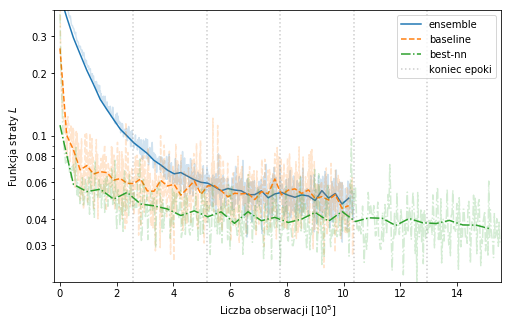

In [9]:
plt.figure(figsize=(8, 5))
linestyles = ["-", "--", "-."]
for j, (k, v) in enumerate(loss_dict.items()):
    mean_n = 11
    mean_n2 = 184
    mult = 1e5
    train_loss = np.squeeze(np.load("models/train_losses_" + v))
    length = len(train_loss)*batch_dict[k]
    train_loss2 = np.mean(train_loss.reshape(-1, mean_n2), axis=1)
    train_loss = np.mean(train_loss.reshape(-1, mean_n), axis=1)
    
    val_loss = np.squeeze(np.load("models/val_losses_" + v))
    val_loss2 = np.mean(val_loss.reshape(-1, mean_n2), axis=1)
    val_loss = np.mean(val_loss.reshape(-1, mean_n), axis=1)
    print(k)
    plt.semilogy(np.arange(len(val_loss))*mean_n*batch_dict[k]/mult, 
                 val_loss, alpha=0.2, linestyle=linestyles[j])
    plt.semilogy(np.arange(len(val_loss2))*(mean_n2+1)*batch_dict[k]/mult, 
                 val_loss2, color="C" + str(j), label=k, linestyle=linestyles[j])
    
for i in range(1, int(length/259042)):
    label = ""
    if i == 1:
        label = "koniec epoki"
    plt.axvline((i*259042/mult), alpha=0.4, color="grey", label=label, linestyle=":")
        
plt.ylim((2e-2, 4e-1))
plt.xlim((-0.2, len(train_loss2)*mean_n2*batch_dict[k]/mult))
plt.xlabel("Liczba obserwacji " + r"$[10^5]$")
plt.ylabel("Funkcja straty " + r"$L$")
plt.yticks([3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1], 
           [3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1])
plt.legend()
plt.savefig("praca/loss_all.png", dpi=500)
plt.show()

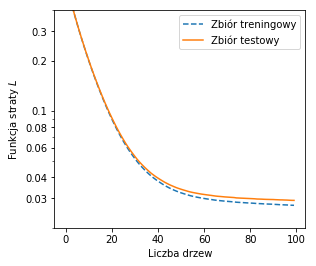

In [14]:
train_loss = np.squeeze(np.load("models/train_losses_xgb_whole_data.npy"))
val_loss = np.squeeze(np.load("models/val_losses_xgb_whole_data.npy"))
plt.figure(figsize=(4.5, 4))
plt.semilogy(np.arange(len(train_loss)), train_loss, linestyle="--", label="Zbiór treningowy")
plt.semilogy(np.arange(len(val_loss)), val_loss, label="Zbiór testowy")
plt.ylim((2e-2, 4e-1))
plt.xlabel("Liczba drzew")
plt.ylabel("Funkcja straty " + r"$L$")
plt.yticks([3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1], 
           [3e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1])
plt.legend(loc=1)
plt.savefig("praca/loss_xgb.png", dpi=500)
plt.show()